# Extracting regional values from Met Office Global meteorological data

## Process
This notebook runs you through how to extract spatial mean values from gridded data using shapefiles. The process includes:
1. Loading the gridded data from NetCDF files into memory using Iris (using [lazy loading](https://scitools.org.uk/iris/docs/latest/userguide/real_and_lazy_data.html)).
2. Subset the global data to only include the USA, improving the processing time.
3. Load the Shapefile for the regions we want to subset with.
4. Define the functions to be used in the pipeline.
5. Loop through all the regions in the shapefile; subsetting, collapsing and saving out to a CSV file for each region.
6. Load all the region CSVs, collate into one large DataFrame and save out to CSV.

## Method
This process uses the polygon of a region (from the shapefile) to subset the gridded data by getting the **latitude-longitude bounding box** of the polygon, as described in this diagram:

<img src="images/coarse_spatial_mean_gridded.png" alt="Lat-Lon bounding box using polygon" style="height: 400px;"/> 

Each grid cell (small latitude-longitude box) contains a single value for a meteorological variable. The single value of that variable for the whole region/polygon is the mean of all the grid cell values in the bounding box i.e. lat-lon spatial mean.

For example, here we have air temperature values in a bounding box that covers the a polygon. The temperature value for the region is the mean value of the temperatures in the boundind box - 20.9°C.

<img src="images/spatial_mean_example.png" alt="The mean value for the temperature is 20.9°C" style="height: 400px;"/> 

#### Time
Of course we have ignored the time axis in this example, which is present in the gridded data but is handled for us by the Iris library as just another dimension. In this notebook we use daily data and will simply store the date for each value in the final tabular data.

#### Improvements
This process could be more accurate by only using the grid cells which actually overlap with the polygon and by weighting the grid cells according to how much of their area is within the polygon. Improvements like these are coming.

## Setup

In [47]:
#Data
import iris
import cartopy.io.shapereader as shpreader
import pandas as pd
import cftime

#Plotting
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline

#System
import os
import sys
import glob
import datetime

#Met Office utils
import shape_utils as shape

#Supress warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Load Met Office Global Data

The files for each variable are contained in a separate folder.

In [10]:
#List all the filepaths and store in a dict with each variable as a key
folder = '/data/met-office/open-license/metoffice_global_daily/'
filepaths = {path: glob.glob(os.path.join(folder, path, '*.nc')) for path in os.listdir(folder)}
variables = [v for v in list(filepaths.keys()) if os.path.isdir(os.path.join(folder,v))]

print(variables)
print(f'Number of files for each variable: {len(filepaths[variables[0]])}')

['cldbase_max', 'cldfrac_max', 'cldfrac_min', 'cldbase_min', 'pmsl_max', 'pmsl_mean', 'cldbase_mean', 'pmsl_min', 'sh_max', 'cldfrac_mean', 'sw_max', 'precip_max', 'sh_min', 'precip_mean', 'sw_mean', 't1o5m_mean', 't1o5m_max', 'windgust_min', 'windspeed_max', 't1o5m_min', 'windgust_max', 'windgust_mean', 'sh_mean', 'windspeed_mean', 'windspeed_min']
Number of files for each variable: 213


In [14]:
# Let's just have windspeed_max
variables = ['windspeed_max']

In [16]:
%%time
#Run through all the variables and append the loaded cubes to a CubeList
cubes = iris.cube.CubeList([])

for var in variables:
    cubes.extend(iris.load(filepaths[var]))
    
print(cubes)

0: cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas / (kft) (time: 213; latitude: 1920; longitude: 2560)
1: specific_humidity / (1)             (time: 213; latitude: 1920; longitude: 2560)
2: air_temperature / (K)               (time: 213; latitude: 1920; longitude: 2560)
3: wind_speed / (m s-1)                (time: 213; latitude: 1921; longitude: 2560)
CPU times: user 1min 3s, sys: 8.36 s, total: 1min 11s
Wall time: 1min 39s


## 2. Subset global data to the country we want

In [17]:
#Subset the cubes to just the USA
us_latlon = ((18, 75), (-179, -65))
us_cubes = iris.cube.CubeList([cube.intersection(latitude=us_latlon[0], longitude=us_latlon[1]) for cube in cubes])
print(us_cubes)

0: cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas / (kft) (time: 213; latitude: 608; longitude: 811)
1: specific_humidity / (1)             (time: 213; latitude: 608; longitude: 811)
2: air_temperature / (K)               (time: 213; latitude: 608; longitude: 811)
3: wind_speed / (m s-1)                (time: 213; latitude: 609; longitude: 810)


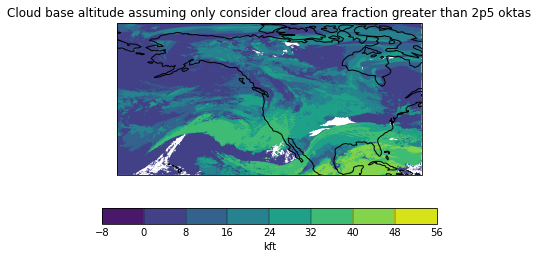

In [18]:
#Plot the subset to check that we have the right area
qplt.contourf(us_cubes[0][0])
plt.gca().coastlines()

In [19]:
#Extract the coordinate reference system from one of the cubes. We will use this later.
CRS = us_cubes[0].coord_system()
CRS

GeogCS(6371229.0)

### 3. Load shapefile containing region polygons

In [22]:
#Load the shapefile
shapefile = '/data/met-office/open-license/shapefiles/USA/US_COUNTY_POP.shx'
regions_reader = shpreader.Reader(shapefile)

In [23]:
#How many regions are included?
len([record for record in regions_reader.records()])

3142

In [24]:
#Let's take a look at one
next(regions_reader.records())

<Record: <shapely.geometry.polygon.Polygon object at 0x7f351ebff610>, {'OBJECTID': 1, 'NAME': 'Autauga', 'STATE_NAME': 'Alabama', 'STATE_FIPS': '01', 'CNTY_FIPS': '001', 'FIPS': '01001', 'POPULATION': 56903, 'POP_SQMI': 94.2, 'POP2010': 54571, 'POP10_SQMI': 90.3, 'WHITE': 42855, 'BLACK': 9643, 'AMERI_ES': 232, 'ASIAN': 474, 'HAWN_PI': 32, 'HISPANIC': 1310, 'OTHER': 466, 'MULT_RACE': 869, 'MALES': 26569, 'FEMALES': 28002, 'AGE_UNDER5': 3579, 'AGE_5_9': 3991, 'AGE_10_14': 4290, 'AGE_15_19': 4290, 'AGE_20_24': 3080, 'AGE_25_34': 6487, 'AGE_35_44': 8243, 'AGE_45_54': 8205, 'AGE_55_64': 5860, 'AGE_65_74': 4013, 'AGE_75_84': 1982, 'AGE_85_UP': 551, 'MED_AGE': 36.9, 'MED_AGE_M': 35.9, 'MED_AGE_F': 37.8, 'HOUSEHOLDS': 20221, 'AVE_HH_SZ': 2.68, 'HSEHLD_1_M': 2012, 'HSEHLD_1_F': 2429, 'MARHH_CHD': 5522, 'MARHH_NO_C': 5845, 'MHH_CHILD': 558, 'FHH_CHILD': 1821, 'FAMILIES': 15064, 'AVE_FAM_SZ': 3.13, 'HSE_UNITS': 22135, 'VACANT': 1914, 'OWNER_OCC': 15248, 'RENTER_OCC': 4973, 'NO_FARMS17': 371.0, 'A

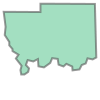

In [25]:
next(regions_reader.geometries())

In [26]:
#We will use a list of the region IDs to loop through later
region_ids = [record.attributes['OBJECTID'] for record in regions_reader.records()]

In [27]:
print(region_ids[0], region_ids[-1])

1 3142


In [28]:
#Helper function to get the record from the reader
def get_region_record(target, shapefile=regions_reader, attribute='OBJECTID'):
    '''
    Get the geometries for the specified target.
    
    '''
    result = None
    for record in shapefile.records():
        location = record.attributes[attribute]
        if location == target:
            result = record
            break
    if result is None:
        emsg = f'Could not find region with {attribute} "{target}".'
        raise ValueError(emsg)
    return result

In [29]:
#Create a random ID generator
from random import randint
def rand_id(ids=region_ids): 
    return randint(ids[0], ids[-1])

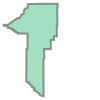

In [38]:
#Get a random geometry to check it's all working as expected
get_region_record(rand_id(), regions_reader).geometry

## 4. Define the functions to be used in the pipeline.

In [45]:
def parse_data_name(cube):
    name = cube.name()
    method = cube.cell_methods[0].method.replace('imum', '')
    units = cube.units
    
    if name == 'm01s01i202':
        name = 'short_wave_radiation'
        units = 'W/m2'
    
    return f'{name}_{method} ({units})'

def get_date(dt):
    if isinstance(dt, cftime.real_datetime):
        date = dt.date()
    else:
        date = datetime.datetime(dt.year, dt.month, dt.day).date()

    return date

In [40]:
def extract(location, cubes=us_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
#     cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    return cut_cubes

In [41]:
def extract_collapse_df(location, cubes=us_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
    cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    time = cubes_col[0].coord('time')
    length = len(time.points)
    data = {'objectid': [location]*length,
            'fips': [region.attributes['FIPS']]*length,
            'county_name': [region.attributes['NAME']]*length,
            'state_name': [region.attributes['STATE_NAME']]*length,
            'date': [get_date(cell.point) for cell in time.cells()]}
    data.update({parse_data_name(cube): cube.data for cube in cubes_col})
    
    df = pd.DataFrame(data, columns=COL_ORDER)

    return df

3097
0: cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas / (kft) (time: 213; latitude: 6; longitude: 5)
1: specific_humidity / (1)             (time: 213; latitude: 6; longitude: 5)
2: air_temperature / (K)               (time: 213; latitude: 6; longitude: 5)
3: wind_speed / (m s-1)                (time: 213; latitude: 6; longitude: 6)


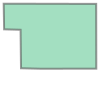

In [43]:
id_ = rand_id()
print(id_)
print(extract(id_, us_cubes, attribute='OBJECTID'))
display(get_region_record(id_, regions_reader, 'OBJECTID').geometry)

## 5. Build a data frame

In [51]:
#Set the order of the columns in the dataframes we will create
col0 = ['objectid', 'fips', 'county_name', 'state_name', 'date']
col1 = [parse_data_name(cube) for cube in us_cubes]
COL_ORDER = tuple(col0 + sorted([c for c in col1 if c not in col0]))
COL_ORDER

('objectid',
 'fips',
 'county_name',
 'state_name',
 'date',
 'air_temperature_max (K)',
 'cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas_max (kft)',
 'specific_humidity_max (1)',
 'wind_speed_min (m s-1)')

In [52]:
#Let's look at the cubes we are going to 
print(us_cubes)

0: cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas / (kft) (time: 213; latitude: 608; longitude: 811)
1: specific_humidity / (1)             (time: 213; latitude: 608; longitude: 811)
2: air_temperature / (K)               (time: 213; latitude: 608; longitude: 811)
3: wind_speed / (m s-1)                (time: 213; latitude: 609; longitude: 810)


In [58]:
%%time
#  Create a dataframe for a given id
df_ex = extract_collapse_df(id_)
df_ex

CPU times: user 10.6 s, sys: 27.6 s, total: 38.2 s
Wall time: 1min 2s


,objectid,fips,county_name,state_name,date,air_temperature_max (K),cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas_max (kft),specific_humidity_max (1),wind_speed_min (m s-1)
0,3097,55097,Portage,Wisconsin,2020-01-01,273.408844,22.324413,0.003597,2.677083
1,3097,55097,Portage,Wisconsin,2020-01-02,274.037506,24.845182,0.003906,3.548611
2,3097,55097,Portage,Wisconsin,2020-01-03,273.587494,5.350586,0.003800,1.517361
3,3097,55097,Portage,Wisconsin,2020-01-04,270.864075,3.644596,0.002954,1.409722
4,3097,55097,Portage,Wisconsin,2020-01-05,273.501556,19.104948,0.003687,1.892361
...,...,...,...,...,...,...,...,...,...
208,3097,55097,Portage,Wisconsin,2020-07-27,299.456238,39.169239,0.017611,2.437500
209,3097,55097,Portage,Wisconsin,2020-07-28,299.382294,9.572526,0.014242,2.659722
210,3097,55097,Portage,Wisconsin,2020-07-29,299.271362,34.117870,0.015104,1.142361
211,3097,55097,Portage,Wisconsin,2020-07-30,297.724487,37.481739,0.015112,1.465278


In [59]:
## 6. Loop over this and write to CSVs

In [72]:
#For now let's assume we haven't written any files, so we will loop through all the region IDs
unwritten = region_ids
start =0
stop = len(unwritten)
out_dir = '/home/jovyan/shape-data-out/'
os.makedirs(out_dir, exist_ok=True)

In [ ]:
%%time
#This will loop through all the region IDs, executing extract_collapse_df for each region and saving it to a CSV file
#Any errors will be caught and printed, but the loop will continue onto the next ID
# Will write to `out_dir`

for location in unwritten[start:]:
    try:
        df = extract_collapse_df(location)
        fname = df['fips'][0]
        county = df['county_name'][0]
        state = df['state_name'][0]
        df.to_csv(f'{out_dir}/us_{fname}_daily_data.csv', index=False)
        print(f'  [{location}] {fname}, {county}, {state}: Success')
    except Exception as e:
        print(f'x [{location}] {fname}, {county}, {state}: Error \n  x  {e}')